In [1]:
import utils
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# Preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from transformer import DataFrameSelecter
from transformer import DiscountConverter
from transformer import DateToWeekConverter
from transformer import CategoryConverter

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.model_selection import train_test_split

# Machine learning models
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

## Acquire data

In [2]:
train = utils.load_data('ccf_offline_stage1_train.csv')
test = utils.load_data('ccf_offline_stage1_test_revised.csv') 

In [3]:
train.head(10)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,4663,11002.0,150:20,1.0,20160528.0,NaN
2,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
3,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
4,1439408,2632,8591.0,20:1,0.0,20160613.0,NaN
5,1439408,2632,NaN,NaN,0.0,NaN,20160516.0
6,1439408,2632,8591.0,20:1,0.0,20160516.0,20160613.0
7,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN
8,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN
9,2029232,450,1532.0,30:5,0.0,20160530.0,NaN


In [4]:
train['Date_received'] =  pd.to_datetime(train['Date_received'], format='%Y%m%d')
test['Date_received'] =  pd.to_datetime(train['Date_received'], format='%Y%m%d')
train['Date'] =  pd.to_datetime(train['Date'], format='%Y%m%d')

## Make labels

In [5]:
train['label'] = 1
train.loc[train['Date'].isnull() | train['Coupon_id'].isnull(), 'label'] = 0
train.loc[(train['Date'] - train['Date_received']).dt.days > 15, 'label'] = 0

In [6]:
train.loc[train['label'] == 1].head(5)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label
33,1113008,1361,11166.0,20:1,0.0,2016-05-15,2016-05-21,1
38,2881376,8390,7531.0,20:5,0.0,2016-03-21,2016-03-29,1
69,114747,6901,2366.0,30:5,0.0,2016-05-23,2016-06-05,1
76,114747,5341,111.0,30:5,0.0,2016-02-07,2016-02-18,1
77,114747,5341,7751.0,50:10,0.0,2016-01-27,2016-01-28,1


In [7]:
train.loc[train['label'] == 1].count()

User_id          64395
Merchant_id      64395
Coupon_id        64395
Discount_rate    64395
Distance         57060
Date_received    64395
Date             64395
label            64395
dtype: int64

In [8]:
train.loc[train['label'] == 0].count()

User_id          1690489
Merchant_id      1690489
Coupon_id         988887
Discount_rate     988887
Distance         1591821
Date_received     988887
Date              712589
label            1690489
dtype: int64

In [9]:
64395 / 1690489

0.038092528256616874

## Build custom transformers for data preprocessing pipelines

**Convert "Date_received" to weekdays, and then to onehot matrix.**

In [10]:
date_pipeline = Pipeline([
    ('selecter', DataFrameSelecter(attribute_names=['Date_received'])),
    ('week_converter', DateToWeekConverter()),
    ('one_hot', OneHotEncoder(categories="auto")),
])


**Fill NA with 0 in "Discount_rate" feature,  make elements in the same format, and scale them.**

In [11]:
discount_pipeline = Pipeline([
    ('selecter', DataFrameSelecter(attribute_names=['Discount_rate'])),
    ('discount_converter', DiscountConverter()),
    ('std_scaler', StandardScaler()),
])

**Categorize "Merchant_id" feature into onehot matrix**

In [12]:
Merchant_pipeline = Pipeline([
    ('selecter', DataFrameSelecter(attribute_names=['Merchant_id'])),
    ('Category_converter', CategoryConverter(scale=1800)),
    ('one_hot', OneHotEncoder(categories="auto")),
])

**Scale "Distance" feature"**

In [13]:
distance_pipeline = Pipeline([
    ('selecter', DataFrameSelecter(attribute_names=['Distance'])),
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

**Combine different preprocessing pipelines**

In [14]:
full_pipeline = FeatureUnion(transformer_list=[
    ("date_pipeline", date_pipeline),
    ("discount_pipeline", discount_pipeline),
    ("merchant_pipeline", Merchant_pipeline),
    ("distance_pipeline", distance_pipeline),
])

In [15]:
y_train = train["label"]
X_train = full_pipeline.fit_transform(train)

**Oversampling with SMOTE method**

In [16]:
Counter(y_train)

Counter({0: 1690489, 1: 64395})

In [17]:
sm = SMOTE(random_state=42, sampling_strategy=0.25)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [18]:
Counter(y_train)

Counter({0: 1690489, 1: 422622})

**Split training dataset into training dataset and validation set**

In [19]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train,
)

## Select and train a model
**Linear Regression--Underfitting**

In [20]:
log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

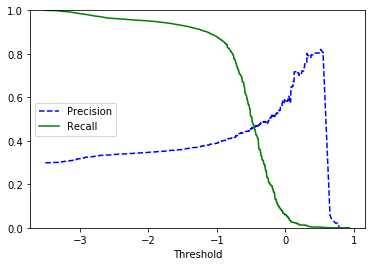

In [21]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])

y_train_scores_log = log_reg.decision_function(X_train)
precisions_log, recalls_log, thresholds_log = precision_recall_curve(
    y_train, y_train_scores_log
)
plot_precision_recall_vs_threshold(precisions_log, recalls_log, thresholds_log)

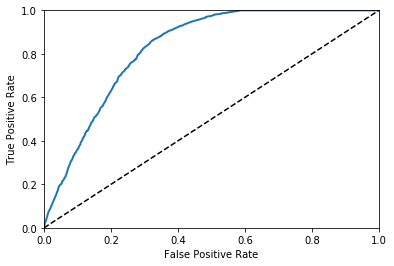

In [22]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

fpr_log, tpr_log, thresholds_log = roc_curve(y_train, y_train_scores_log)
plot_roc_curve(fpr_log, tpr_log)

In [24]:
roc_score_log = roc_auc_score(y_train, y_train_scores_log)
print(roc_score_log)

0.8257721336813328


**Try XGBoost**

In [25]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 5,
    'min_child_weight': 5,
    'learning_rate': 0.2,
    'silent': False,
    'n_estimater': 140,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 1,
    'verbose': False,
}

In [26]:
xgb_cls = XGBClassifier(**params)
xgb_cls.fit(X_train, y_train)

[14:29:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[14:29:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[14:29:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[14:29:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[14:29:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[14:29:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[14:29:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[14:29:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[14:29:38] /work

[14:30:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[14:30:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[14:30:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[14:30:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[14:30:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[14:30:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[14:30:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[14:30:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[14:30:10] /work

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimater=140,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
       subsample=0.8, verbose=False)

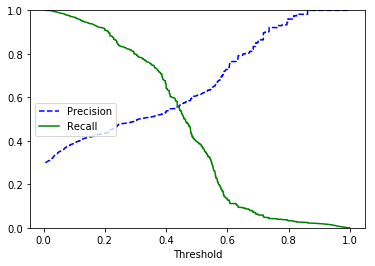

In [27]:
y_train_scores_xgb = xgb_cls.predict_proba(X_train)[:, 1]
precisions_xgb, recalls_xgb, thresholds_xgb = precision_recall_curve(
    y_train, y_train_scores_xgb
)
plot_precision_recall_vs_threshold(precisions_xgb, recalls_xgb, thresholds_xgb)

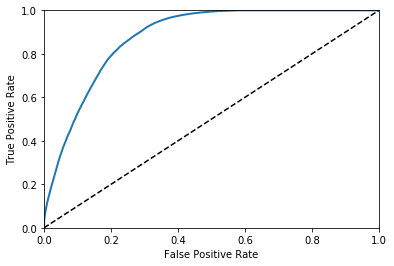

In [28]:
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_train, y_train_scores_xgb)
plot_roc_curve(fpr_xgb, tpr_xgb)

In [31]:
roc_score_xgb = roc_auc_score(y_train, y_train_scores_xgb)
print(roc_score_xgb)

0.878361549168146


## Make submission file

In [ ]:
# test prediction for submission
y_test_pred = xgb_cls.predict_proba(full_pipeline.fit_transform(test))
test_copy = test[['User_id','Coupon_id','Date_received']].copy()
test_copy['Probability'] = y_test_pred[:,1]
test_copy.head(5)
test_copy.to_csv('submit1.csv', index=False, header=False)